In [1]:
from glob import iglob
from itertools import chain
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
datasets = (
    pd
    .read_excel("Data/Run list.xlsx", sheet_name="Datasets")
    .set_index("Dataset")
)
datasets.head()

,First Run num,Last Run num,Wavelength (eV),Undulators,Opt ph offset (rad),Opt ph offset err (rad)
Dataset,,,,,,
alt1,186,203,15.9,5U(ω)+1U(2ω),NaN,NaN
alt2,252,314,14.3,5U(ω)+1U(2ω),NaN,NaN
alt3,333,365,14.3,5U(ω)+1U(2ω),NaN,NaN
alt4,453,460,14.3,5U(ω)+1U(2ω),NaN,NaN
bad,-1,-1,NaN,NaN,NaN,NaN


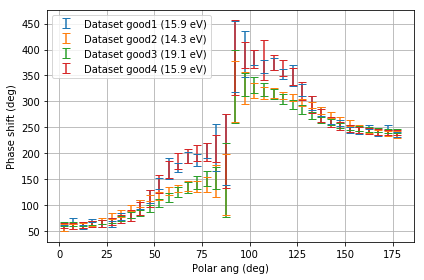

In [3]:
def _read(filename: str) -> dict:
    with open(filename, "r") as fp:
        d = json.load(fp)

    for r in d["Grouped by"]["Polar ang fr (deg)"]:
        shift = {
            p["Name"]: p
            for p in r["Model result"]["Params"]
        }["shift"]
        yield {
            "Dataset": d["Dataset"],
            "Polar ang fr (deg)": r["Polar ang fr (deg)"],
            "Polar ang to (deg)": r["Polar ang to (deg)"],
            "Phase shift (rad)": shift["Value"],
            "Phase shift err (rad)": shift["Std err"],
        }


def _calib(df: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "Phase shift (rad)": (df["Phase shift (rad)"] - df["Opt ph offset (rad)"] - 0.8) % (2 * np.pi) + 0.8,
        "Phase shift err (rad)": (df["Phase shift err (rad)"] ** 2 + df["Opt ph offset err (rad)"] ** 2) ** 0.5,
        "Photon energy (eV)": df["Wavelength (eV)"],
        "Polar ang fr (deg)": df["Polar ang fr (deg)"],
        "Polar ang to (deg)": df["Polar ang to (deg)"],
    })


filenames = iglob("Data/Photoelectron yields - *.json")
it = chain.from_iterable((d for d in _read(fn)) for fn in filenames)
data = (
    pd
    .DataFrame([d for d in it])
    .set_index(["Dataset", "Polar ang fr (deg)"], drop=False)
    .merge(datasets, left_index=True, right_index=True)
    .apply(_calib, axis=1)
)


colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
]

plt.figure()
plt.xlabel("Polar ang (deg)")
plt.ylabel("Phase shift (deg)")
for k, c in zip(["good1", "good2", "good3", "good4"], colors):
    sliced = data.loc[k, :]
    dx = sliced.index[1] - sliced.index[0]
    plt.errorbar(
        (sliced["Polar ang fr (deg)"] + sliced["Polar ang to (deg)"]) / 2,
        sliced["Phase shift (rad)"] / np.pi * 180,
        sliced["Phase shift err (rad)"] / np.pi * 180,
        capsize=4,
        fmt=" ",
        label="Dataset {} ({} eV)".format(k, sliced["Photon energy (eV)"].iloc[0]),
    )
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

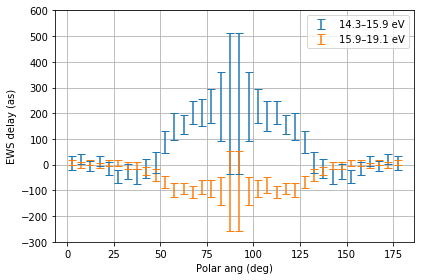

In [4]:
def _average(df: pd.DataFrame) -> pd.Series:
    w = 1 / df["Phase shift err (rad)"] ** 2
    return pd.Series({
        "Phase shift (rad)": (df["Phase shift (rad)"] * w).sum() / w.sum(),
        "Phase shift err (rad)": 1 / w.sum() ** 0.5,
        "Photon energy (eV)": df["Photon energy (eV)"].iloc[0],
        "Polar ang fr (deg)": df["Polar ang fr (deg)"].iloc[0],
        "Polar ang to (deg)": df["Polar ang to (deg)"].iloc[0],
    })


def _sloop(df: pd.DataFrame) -> pd.DataFrame:
    x = df["Photon energy (eV)"].values
    index = pd.Index(x[:-1], name="Photon energy fr (eV)")
    dx = 2 * np.diff(x)
    dy = np.diff(df["Phase shift (rad)"])
    sq = df["Phase shift err (rad)"].values ** 2
    k = 24.1888432651 / 0.0367493
    return pd.DataFrame({
        "EWS delay (as)": dy / dx * k,
        "EWS delay err (as)": (sq[:-1] + sq[1:]) ** 0.5 / dx * k,
        "Photon energy fr (eV)": x[:-1],
        "Photon energy to (eV)": x[1:],
        "Polar ang fr (deg)": df["Polar ang fr (deg)"].iloc[0],
        "Polar ang to (deg)": df["Polar ang to (deg)"].iloc[0],
    }, index=index)


diff = (
    data
    .reset_index(level=1, drop=True)
    .groupby(["Photon energy (eV)", "Polar ang fr (deg)"])
    .apply(_average)
    .sort_index()  # Sort by photon energies
    .reset_index(level=1, drop=True)
    .groupby("Polar ang fr (deg)")
    .apply(_sloop)
)


colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
]

plt.figure()
plt.xlabel("Polar ang (deg)")
plt.ylabel("EWS delay (as)")
for k, c in zip([14.3, 15.9], colors):
    sliced = diff.loc[pd.IndexSlice[:, k], :].reset_index(level=1, drop=True)
    plt.errorbar(
        (sliced["Polar ang fr (deg)"] + sliced["Polar ang to (deg)"]) / 2,
        sliced["EWS delay (as)"],
        sliced["EWS delay err (as)"],
        capsize=4,
        fmt=" ",
        label="{}–{} eV".format(sliced["Photon energy fr (eV)"].iloc[0],
                                sliced["Photon energy to (eV)"].iloc[0]),
    )
plt.ylim(-300, 600)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
with open("Data/Phase shifts - Measured.json", "w") as fp:
    json.dump(
        data
        .drop(columns=["Polar ang fr (deg)"])
        .reset_index()
        .to_dict("records"),
        fp,
        indent=2,
        sort_keys=True,
    )

with open("Data/EWS delays - Measured.json", "w") as fp:
    json.dump(
        diff.to_dict("records"),
        fp,
        indent=2,
        sort_keys=True,
    )